In [1]:
import pandas as pd
df = pd.read_csv("cardinality_benchmark.tsv", sep="\t")

df["hash_name"] = [
    "MetroHasher" if "Hasher64_1" in hash_name else hash_name
    for hash_name in df["hash_name"]
]

df["memory"] = 2**df.precision * df.bits
df["label"] = "HLL"

df

,precision,bits,exact,hll,mle,hash_name,memory,label
0,4,1,42156,18.064531,inf,MetroHasher,16,HLL
1,4,2,42156,86.144000,inf,MetroHasher,32,HLL
2,4,3,42156,1378.304000,inf,MetroHasher,48,HLL
3,4,4,42156,57607.480000,63350.800,MetroHasher,64,HLL
4,4,5,42156,58351.760000,63215.707,MetroHasher,80,HLL
...,...,...,...,...,...,...,...,...
500542,15,5,21699,21838.457000,21839.713,MetroHasher,163840,HLL
500543,15,6,21699,21838.457000,21839.713,MetroHasher,196608,HLL
500544,16,1,21699,21741.576000,21544.344,MetroHasher,65536,HLL
500545,16,2,21699,21741.576000,21741.006,MetroHasher,131072,HLL


In [2]:
df["hll"] /= df.exact
df["mle"] /= df.exact
df["exact"] /= df.exact
df["squared_error_hll"] = (df.exact - df.hll)**2
df["squared_error_mle"] = (df.exact - df.mle)**2
columns = ["squared_error_hll", "squared_error_mle"]
data_hll = df.groupby(["precision", "bits", "memory", "hash_name"])[columns].agg(["mean", "std"])
data_hll = data_hll.reset_index()
data_hll

precision bits  memory                                     hash_name  \
                                                                           
0           4    1      16                                   MetroHasher   
1           4    1      16               highway::builder::HighwayHasher   
2           4    1      16  hyperloglog_rs::hasher_method::SimpleAddHash   
3           4    1      16  hyperloglog_rs::hasher_method::SimpleMulHash   
4           4    1      16                   siphasher::sip::SipHasher13   
..        ...  ...     ...                                           ...   
499        17    6  786432               highway::builder::HighwayHasher   
500        17    6  786432  hyperloglog_rs::hasher_method::SimpleAddHash   
501        17    6  786432  hyperloglog_rs::hasher_method::SimpleMulHash   
502        17    6  786432                   siphasher::sip::SipHasher13   
503        17    6  786432                   siphasher::sip::SipHasher24   

    squared_error_hll           squared_error_mle            
                 mean       std              mean       std  
0            0.993630  0.031707               NaN       NaN  
1            0.993509  0.034167               NaN       NaN  
2            0.999322  0.005431          0.999323  0.005423  
3            0.999584  0.002904          0.999584  0.002903  
4            0.993509  0.034167               NaN       NaN  
..                ...       ...               ...       ...  
499          0.000005  0.000006          0.000005  0.000006  
500          0.999360  0.005106          0.999360  0.005106  
501          0.999597  0.002814          0.999597  0.002814  
502          0.000003  0.000005          0.000003  0.000004  
503          0.000004  0.000005          0.000004  0.000005  

[504 rows x 8 columns]

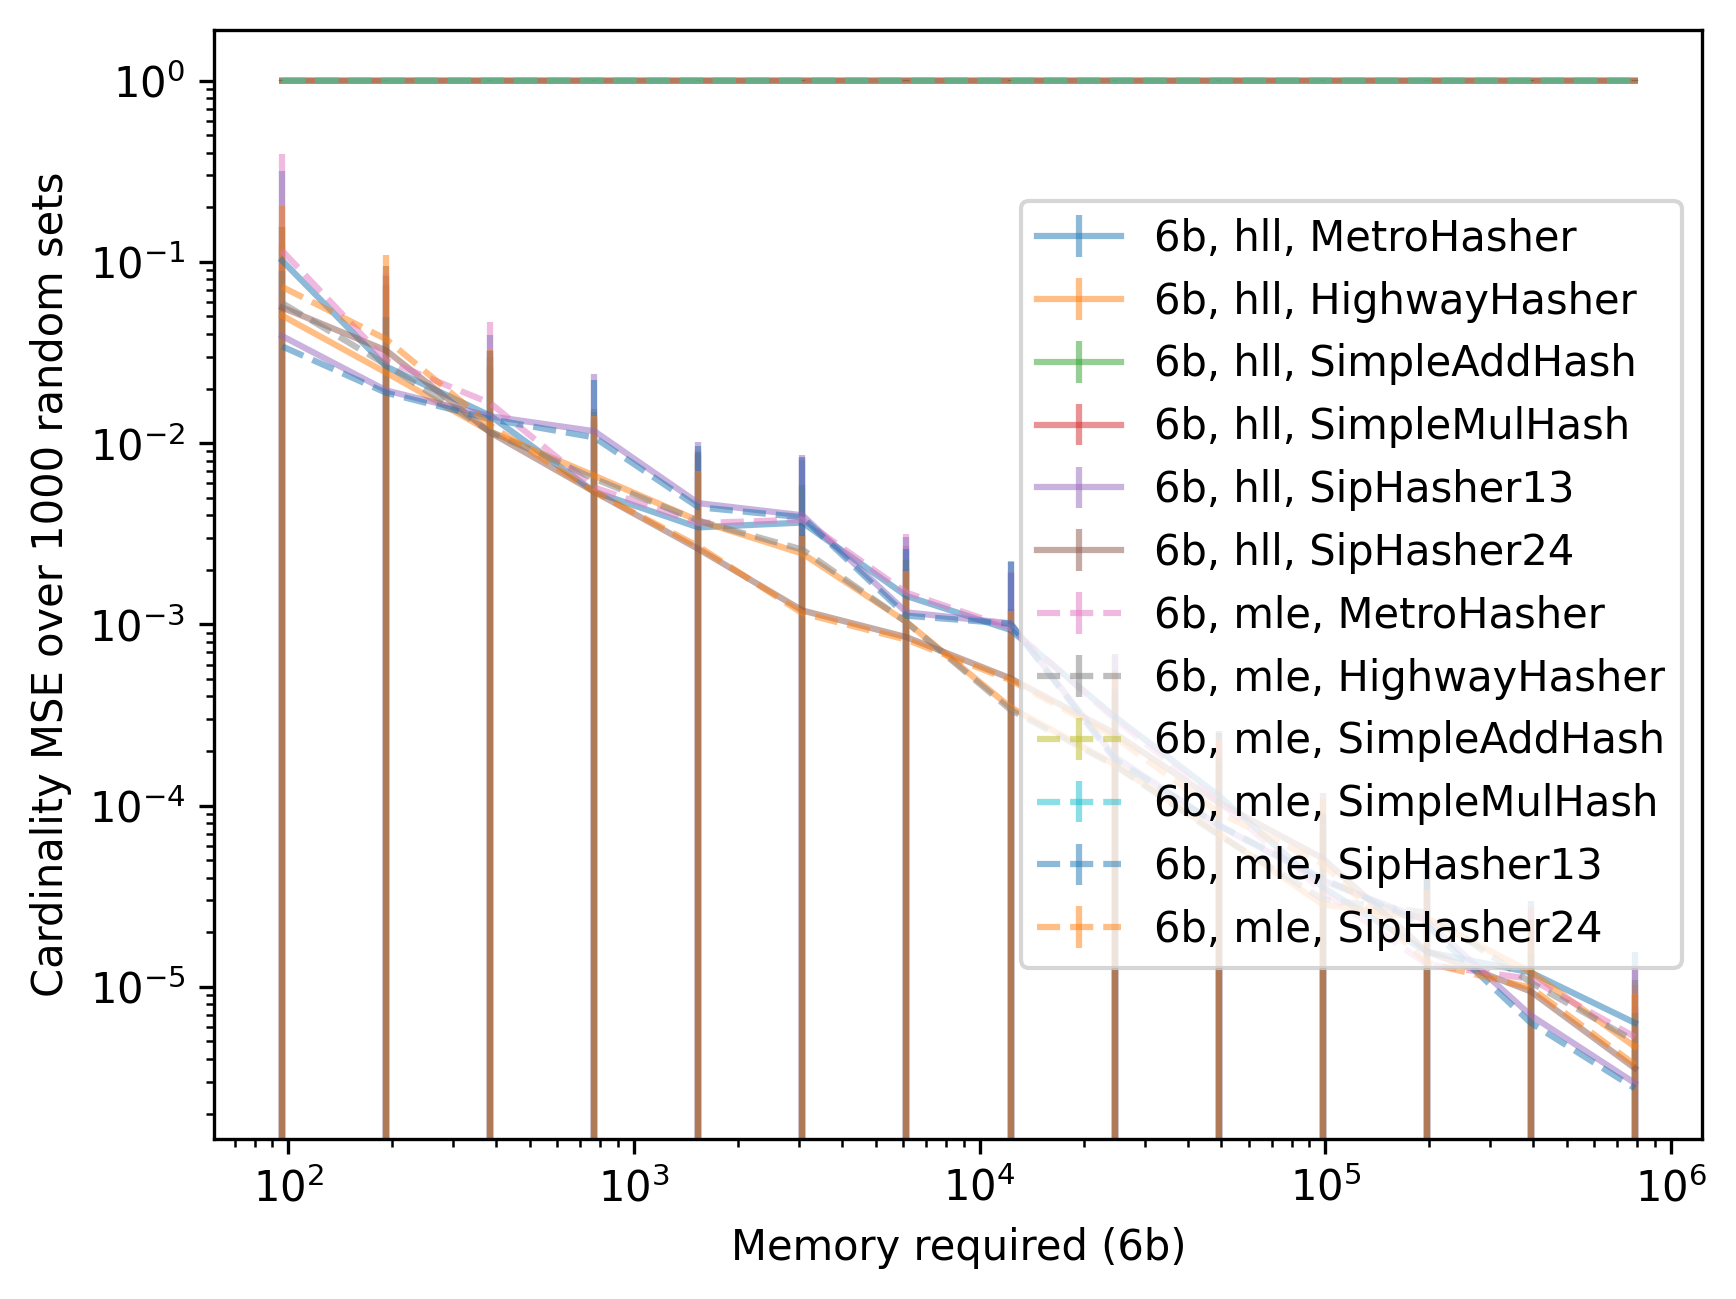

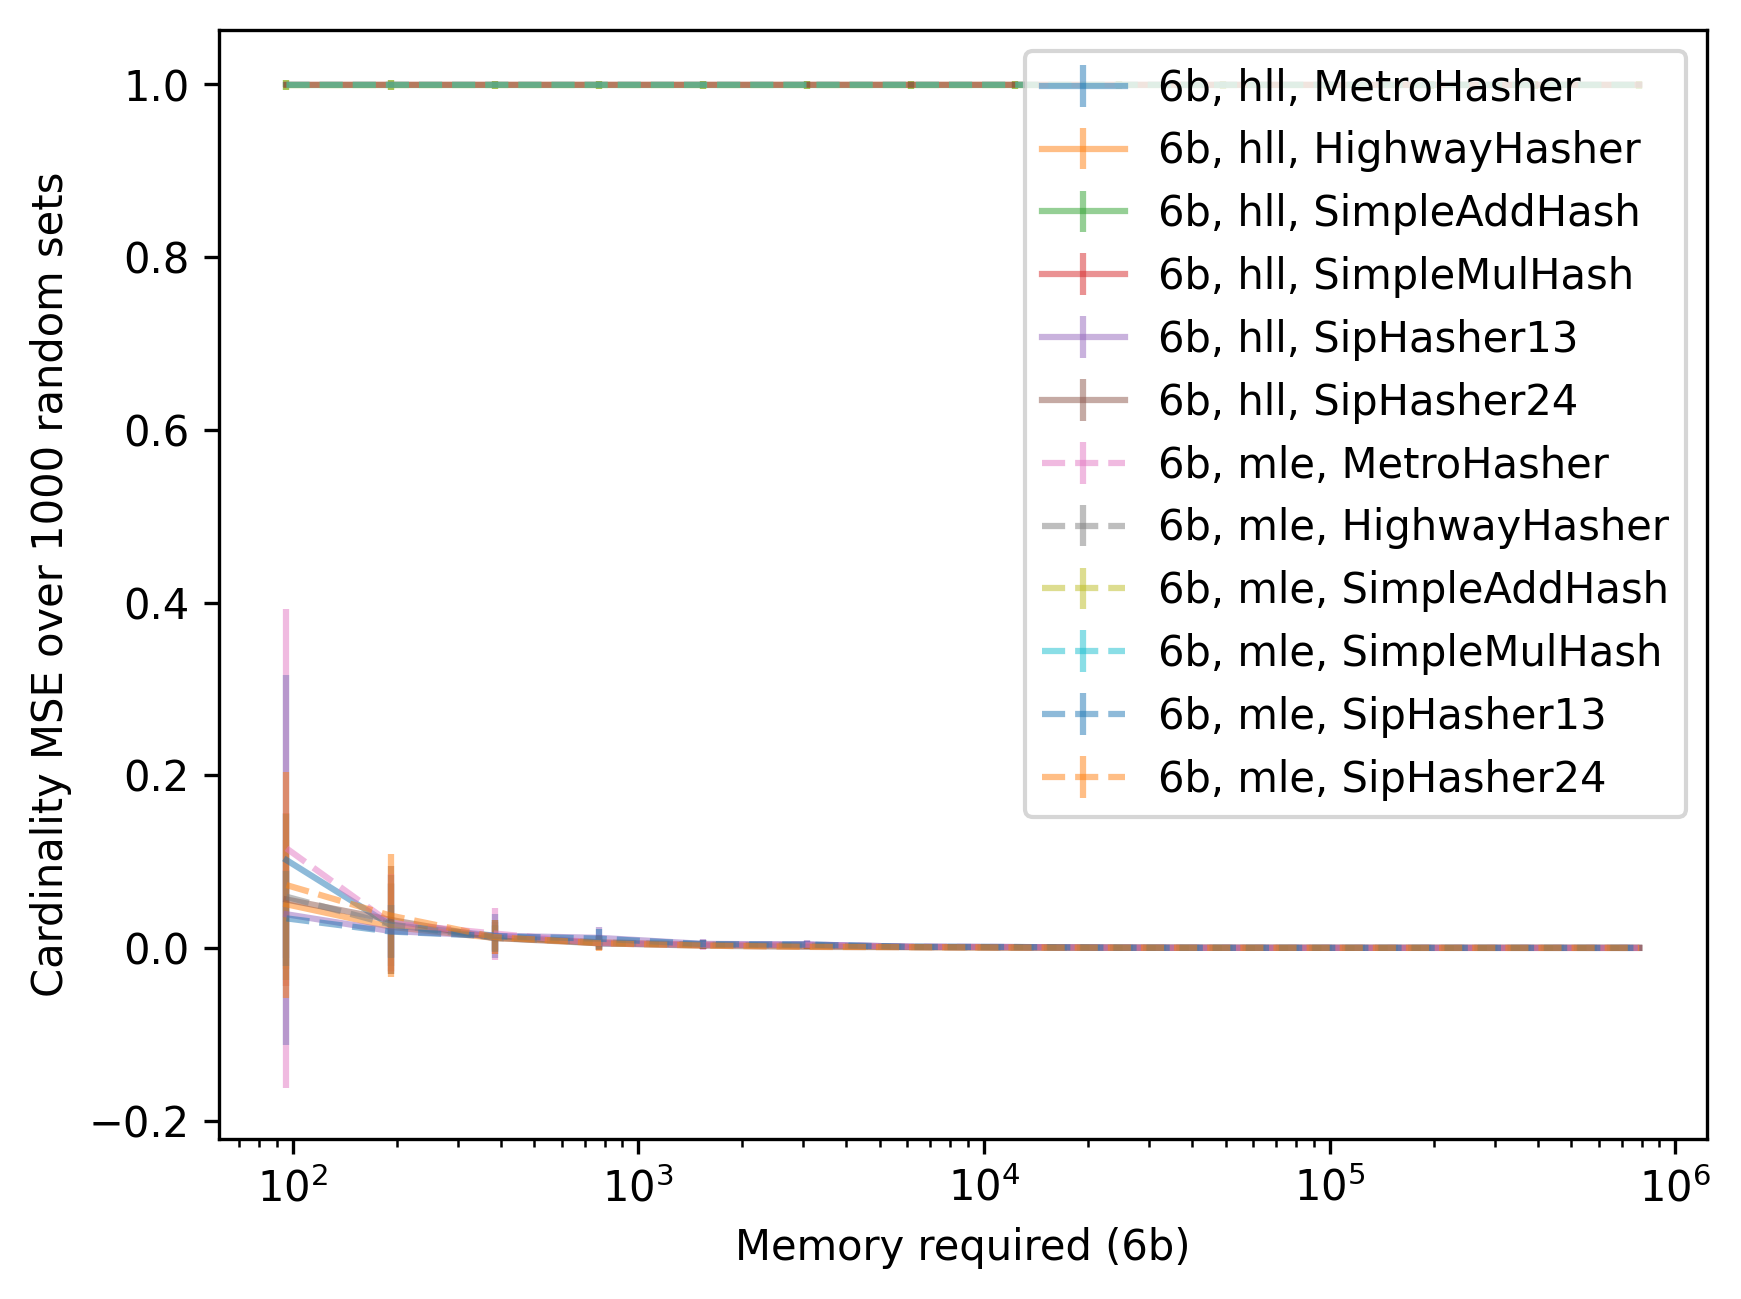

In [3]:
import matplotlib.pyplot as plt

bits_to_skip = (1, 2, 3, 4, 5)


for scale in ("log", "linear"):
    for bits in data_hll["bits"].unique():
        if bits in bits_to_skip:
            continue
        fig, axes = plt.subplots(dpi=300)
        for column in columns:
            for hash_name in data_hll["hash_name"].unique():
                filtered = data_hll[data_hll.bits == bits]
                linestyle = "-" if column == "squared_error_hll" else "--"
                filtered = filtered[filtered.hash_name == hash_name]
                short_hash_name = hash_name.split(":")[-1]
                if len(data_hll["hash_name"].unique()) == 1:
                    short_hash_name = ""
                c = column.split("_")[-1]
                plt.errorbar(
                    filtered.memory,
                    filtered[column]["mean"],
                    filtered[column]["std"],
                    linestyle=linestyle,
                    #marker=hash_name_marker_style[short_hash_name],
                    label=f"{bits}b, {c}, {short_hash_name}",
                    alpha=0.5
                )

        plt.legend()
        plt.xscale("log")
        plt.yscale(scale)
        plt.ylabel("Cardinality MSE over 1000 random sets")
        plt.xlabel(f"Memory required ({bits}b)")
        plt.show()